In [1]:
import sys
sys.path.insert(0, '../gambit')

import os
import sep
import numpy as np
import itertools
from scipy import ndimage
import matplotlib.pyplot as plt

from gambit import create_diff_per_image, clean_data, create_diff_image
from mask import create_segmentation_masks, create_ellipse_mask_from_sep_object,create_bisection_mask
from fits import read_fits, view_fits, write_fits
from spin_parity import read_spin_parity_galaxies_label_from_csv
from matrix import *
from visualize import construct_diff_plot

In [2]:
#DON'T change this:
bands_in_order = ['g','r','i','z','y']

In [3]:
#Change this:
#path_to_input = "/Users/cora-at-work/Desktop/github/spin-parity-catalog/original/galaxies/"
#csv_path = "/Users/cora-at-work/Desktop/github/spin-parity-catalog/table_info/csv_format_of_table/"
path_to_input = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog\\original\\galaxies\\"
csv_path = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog\\table_info\\csv_format_of_table\\"

In [4]:
 #Update these as needed:
table_key = "table4"
use_percentile = False #True -> Percentile, False -> Norm
use_sep = True

In [5]:
def get_galaxy_list():
    return os.listdir(os.path.join(path_to_input,table_key))

def fits_path(name,band):
    return os.path.join(path_to_input,table_key,name,"{}_{}.fits".format(name,band))

def get_csv_path():
    return os.path.join(csv_path,"table_{}.csv".format(table_key.strip()[-1]))

In [6]:
#sep object:
def calc_dist(cm_x,cm_y,el_x,el_y):
    return (((cm_x-el_x)*(cm_x-el_x)) + ((cm_y-el_y)*(cm_y-el_y)))**0.5

def calc_sep_size(a,b):
    return 3.14*a*b

def run_sep(data, cm_x, cm_y):
    #print(np.min(data),np.max(data),np.sum(np.isinf(data)),np.sum(np.isnan(data)))
    data = data.byteswap().newbyteorder()
    bkg = sep.Background(data)
    data_sub = data - bkg
    
    objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
    #view_fits_with_sep_objects(data,objects,2)
    
    the_el_sep = None
    the_el_sep_dist = np.inf
    
    #return
    
    for i in objects:
        #print(i['a'],i['b'],i['x'],i['y'])
        if calc_sep_size(i['a'],i['b']) < 0.001*data.shape[0]*data.shape[1]: continue
        
        d = calc_dist(cm_x,cm_y,i['x'],i['y'])
        if d < the_el_sep_dist:
            the_el_sep = i; the_el_sep_dist = d
            
    if the_el_sep != None:
        the_el = create_ellipse_mask_from_sep_object(the_el_sep,data.shape,r=2)
        #view_fits(the_el)
        return the_el, the_el_sep
    return None

In [7]:
def calculate_center_of_mass(the_mask):
    cm = ndimage.center_of_mass(the_mask)
    return (cm[-1],cm[0])

def get_cms(diff_per,foreground):
    thresholds = []
    above_threshold_cm = []
    below_threshold_cm = []
    
    m, s = np.mean(diff_per[foreground]), np.std(diff_per[foreground])
    
    for i in np.linspace(m-1*s,m+1*s):
        above_area = np.logical_and(foreground,diff_per>=i)
        below_area = np.logical_and(foreground,diff_per<i)
        
        thresholds.append(i)
        above_threshold_cm.append(calculate_center_of_mass(above_area))
        below_threshold_cm.append(calculate_center_of_mass(below_area))
        
    return (thresholds,above_threshold_cm,below_threshold_cm)
        
def diff_cm(diff,foreground, std_range=1):
    xu = []; yu = [] #for above threshold
    xl = []; yl = [] #for below threshold
    
    m, s = np.mean(diff[foreground]), np.std(diff[foreground])
    
    for i in np.linspace(m-std_range*s,m+std_range*s):
        upper_clip = np.logical_and(foreground,diff>=i) #points above threshold
        lower_clip = np.logical_and(foreground,diff<i) #points below threshold
        
        u_cm = calculate_center_of_mass(upper_clip) #center of mass of above threshold
        l_cm = calculate_center_of_mass(lower_clip) #center of mass of below threshold

        xu.append(u_cm[0]);yu.append(u_cm[1])
        xl.append(l_cm[0]);yl.append(l_cm[1])
        
    return (xu,yu,xl,yl)

def visualize_diff_cm(diff,foreground,xu,yu,xl,yl):
    fig, ax = plt.subplots(figsize=(30,20))
    im = ax.imshow(diff, interpolation='nearest', cmap='gray', origin='lower')
    ax.plot(calculate_center_of_mass(foreground)[0],calculate_center_of_mass(foreground)[1], marker='v',color='green')
    ax.plot(xu, yu, color="blue", linewidth=3, alpha=0.5) #center of mass for pixels above threshold
    ax.plot(xl, yl, color="red", linewidth=3, alpha=0.5) #center of mass for pixels below threshold
    plt.show()
    
def construct_radius_graph(foreground, radius_matrix, diff,pos,neg):
    pos_ellipse = np.logical_and(foreground,pos)
    #view_fits(pos_ellipse)
    neg_ellipse = np.logical_and(foreground,neg)
    #view_fits(neg_ellipse)
    xs = radius_matrix[foreground].flatten()
    ys = diff[foreground].flatten()
    plt.scatter(radius_matrix[pos_ellipse].flatten(),diff[pos_ellipse].flatten(),c='g')
    plt.scatter(radius_matrix[neg_ellipse].flatten(),diff[neg_ellipse].flatten(),c='r')
    plt.show()
    
def construst_angle_graph(foreground, disk_angle_matrix, diff,pos,neg):
    pos_ellipse = np.logical_and(foreground,pos)
    neg_ellipse = np.logical_and(foreground,neg)
    #plt.scatter(disk_angle_matrix[pos_ellipse].flatten(),diff[pos_ellipse].flatten(),c='g')
    #plt.scatter(disk_angle_matrix[neg_ellipse].flatten(),diff[neg_ellipse].flatten(),c='r')
    plt.scatter(diff[pos_ellipse].flatten(),disk_angle_matrix[pos_ellipse].flatten(),c='g')
    plt.scatter(diff[neg_ellipse].flatten(),disk_angle_matrix[neg_ellipse].flatten(),c='r')
    plt.show()

In [21]:
def sigmoid_normalize(data,foreground):
    alpha = np.max(data[foreground])-np.min(data[foreground]) #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    beta = alpha/2 + np.min(data[foreground])
    data-=beta
    data*=(1/alpha)
    data=( 1/(1 + np.exp(-data)))
    to_return = np.zeros(data.shape)
    to_return[foreground] = data[foreground]
    return to_return

def diff_graph_point(first_ns,base_ns,pos_el,neg_el,threshold_steps = 17):
    xs = []; ys = []
    for x in np.linspace(0,1,threshold_steps):
        """
        to_view = np.zeros(first_ns.shape)
        to_view_2 = np.zeros(first_ns.shape)
        to_view[first_ns >= x] = 1
        to_view_2[base_ns >= x] = 1
        view_fits(to_view)
        view_fits(to_view_2)
        """
        
        pos_side = (np.sum(first_ns[pos_el] >= x)/np.sum(pos_el)) - (np.sum(base_ns[pos_el] >= x)/np.sum(pos_el))
        neg_side = (np.sum(first_ns[neg_el] >= x)/np.sum(neg_el)) - (np.sum(base_ns[neg_el] >= x)/np.sum(neg_el))
        xs.append(x); ys.append(pos_side-neg_side)
    return (xs,ys)

def ns_graph(ns,pos_el,neg_el,threshold_steps = 17):
    xs = []; ys = []
    for x in np.linspace(np.min(ns),np.max(ns),threshold_steps):
        pos_side = np.sum(ns[pos_el] >= x)/np.sum(pos_el)
        neg_side = np.sum(ns[neg_el] >= x)/np.sum(neg_el)
        xs.append(x); ys.append(pos_side-neg_side)
    plt.plot(xs,ys)
    plt.show()

    """
    xs = []; ys = []
    for x in np.linspace(0,1,threshold_steps):
        pos_side = np.sum(first_ns[pos_el] >= x)/np.sum(pos_el)
        neg_side = np.sum(first_ns[neg_el] >= x)/np.sum(pos_el)
        xs.append(x); ys.append(pos_side-neg_side)
    plt.plot(xs,ys)
    plt.show()
    
    xs = []; ys = []
    for x in np.linspace(0,1,threshold_steps):
        pos_side = np.sum(base_ns[pos_el] >= x)/np.sum(pos_el)
        neg_side = np.sum(base_ns[neg_el] >= x)/np.sum(pos_el)
        xs.append(x); ys.append(pos_side-neg_side)
    plt.plot(xs,ys)
    plt.show()
    """

In [24]:
def construct_diff_percentile(name,first_band,base_band):
    first_band_path = fits_path(name,first_band)
    base_band_path = fits_path(name,base_band)
    
    if not (os.path.exists(first_band_path) and os.path.exists(base_band_path)): 
        print("path does not exist gaurd")
        return None

    first_band_data = clean_data(read_fits(first_band_path)) #added clean to handle infs/ nans
    base_band_data = clean_data(read_fits(base_band_path)) #added clean to handle infs/ nans
    
    if first_band_data.shape != base_band_data.shape: 
        print("shape issue gaurd")
        return None
    
    (foreground,_) = create_segmentation_masks(base_band_data)
    cm_y, cm_x = calculate_center_of_mass(foreground)
    
    if np.sum(foreground) <= 0.01*np.sum(np.shape(base_band_data)): 
        print("small forground gaurd")
        return None
    
    if use_sep:
        the_el, the_el_sep = run_sep(base_band_data, cm_x, cm_y)
        if the_el is None:
            print("issue with sep guard")
            return None
        foreground = the_el
        #view_fits(the_el)
        
    first_ns = sigmoid_normalize(first_band_data,foreground)
    base_ns = sigmoid_normalize(base_band_data,foreground)
    ns=first_ns-base_ns
    
    (pos,neg) = create_bisection_mask(the_el_sep['x'],the_el_sep['y'],the_el_sep['theta'],base_band_data.shape)
    pos_el = np.logical_and(pos,the_el)
    neg_el = np.logical_and(neg,the_el)
    
    print('band pair')
    ns_graph(ns,pos_el,neg_el)
    print('base band')
    ns_graph(base_ns,pos_el,neg_el)
    
    (xs,ys) = diff_graph_point(first_ns,base_ns,pos_el,neg_el)
    return (xs,ys)
    
    #view_fits(pos_el)
    #view_fits(neg_el)
    
    #view_fits(ns*pos_el)
     
    """
    #print(the_el_sep)
    view_fits(first_band_data)
    first_ns = sigmoid_normalize(first_band_data,foreground)
    base_ns = sigmoid_normalize(base_band_data,foreground)
    ns=first_ns-base_ns
    view_fits(ns)
    #write_fits("C:\\Users\\school\\Desktop\\sigmoid_test_with.fits",ns)
    
    diff=create_diff_image(first_band_data,base_band_data,foreground)
    view_fits(diff)
    #write_fits("C:\\Users\\school\\Desktop\\sigmoid_test_without.fits",diff)
    c=ns-diff
    print(np.max(c[foreground]),np.min(c[foreground]))
    view_fits(c)
    """

1 NGC5522 SE
band pair


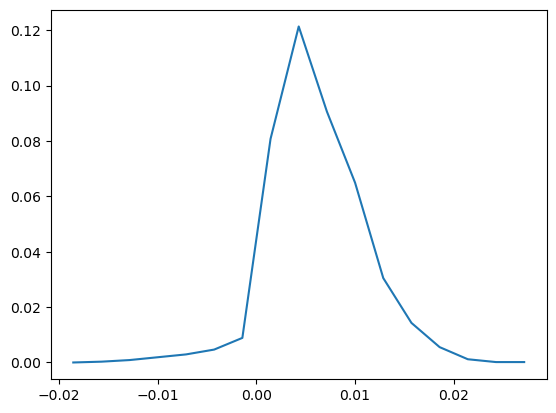

base band


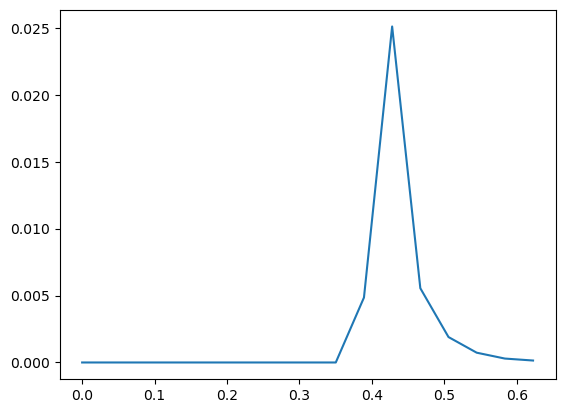

band pair


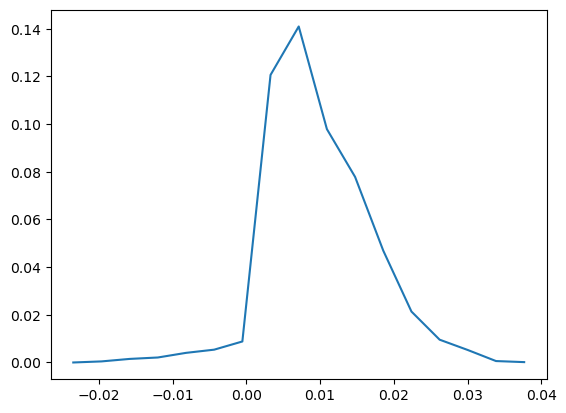

base band


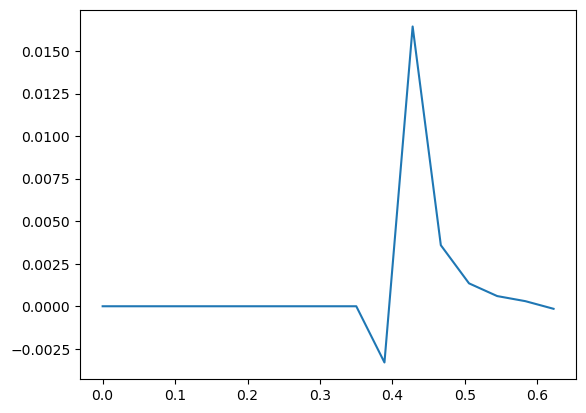

band pair


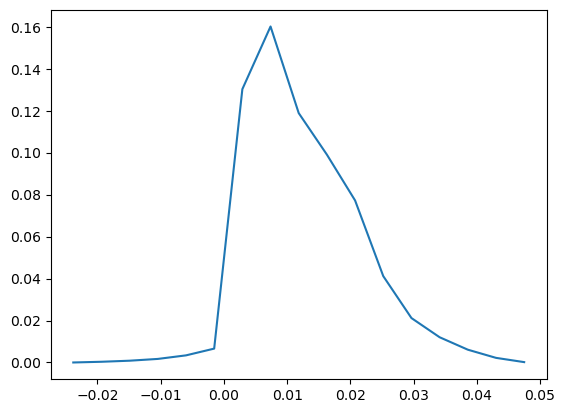

base band


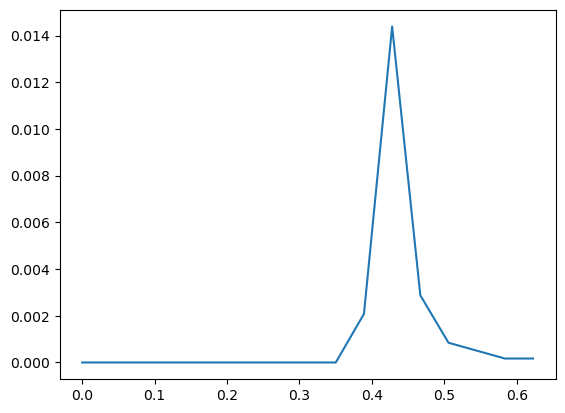

band pair


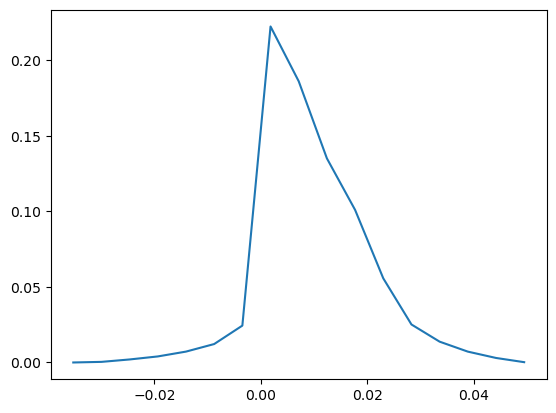

base band


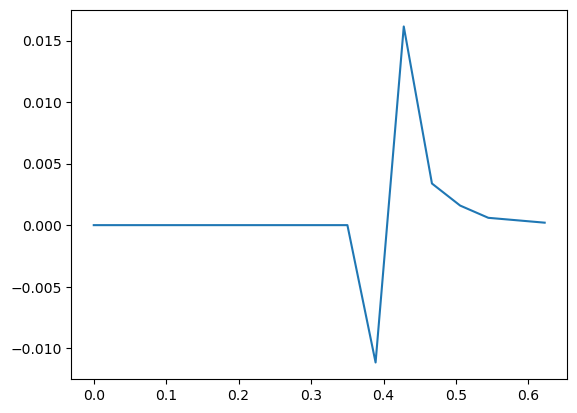

band pair


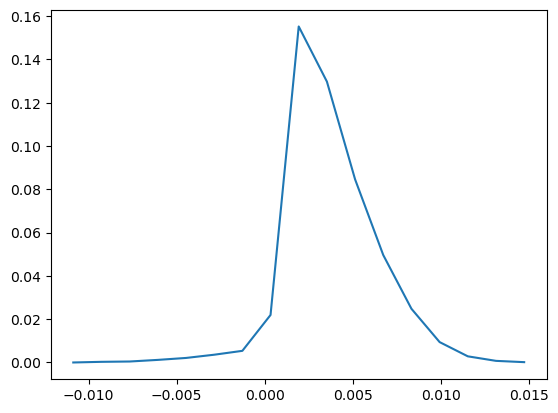

base band


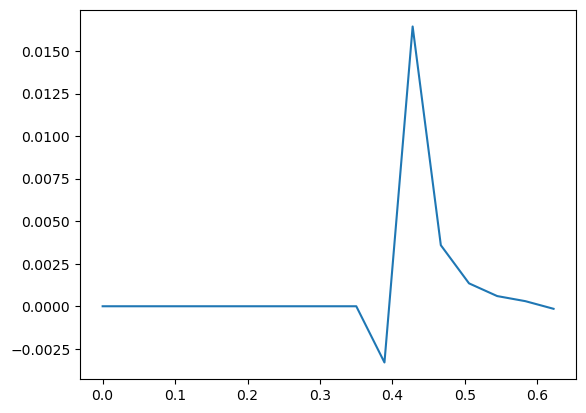

band pair


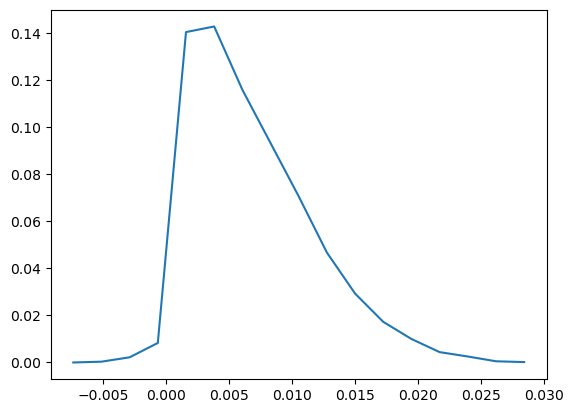

base band


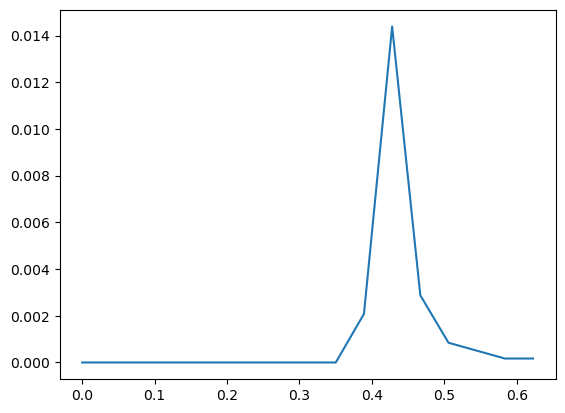

band pair


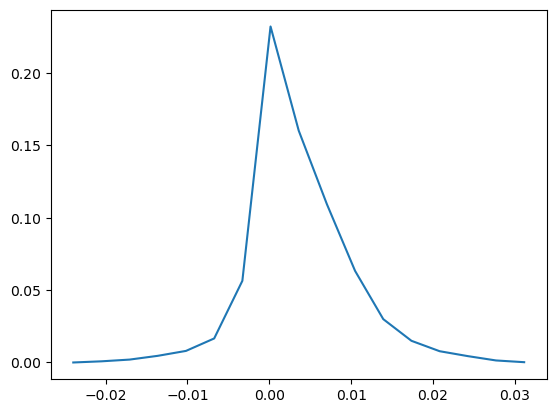

base band


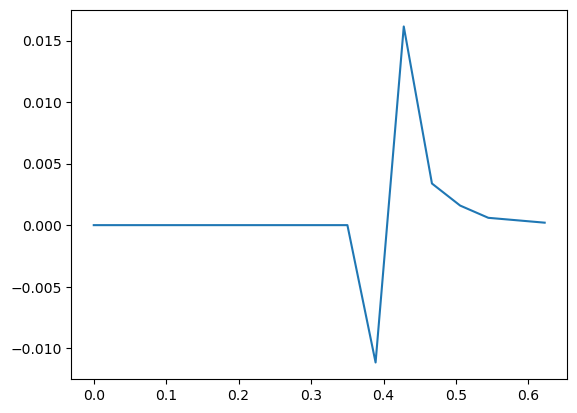

band pair


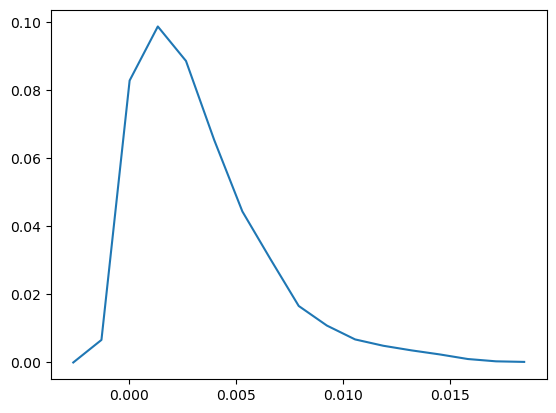

base band


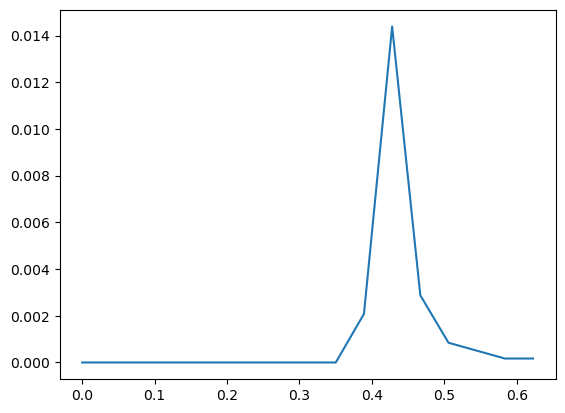

band pair


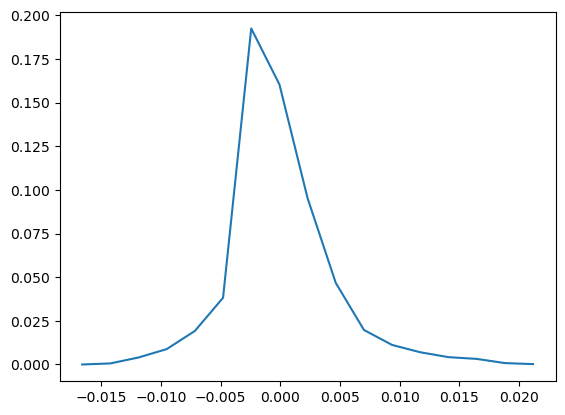

base band


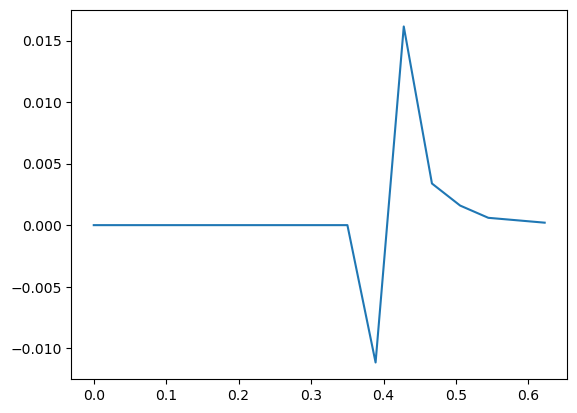

band pair


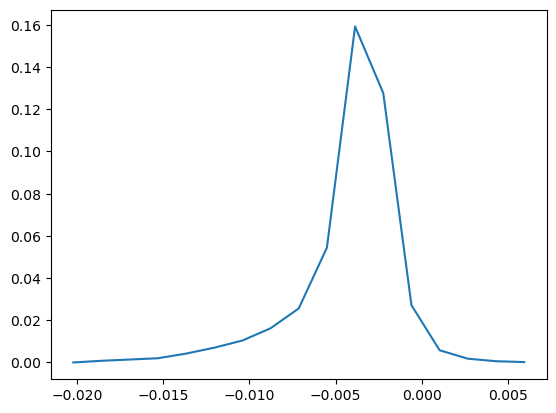

base band


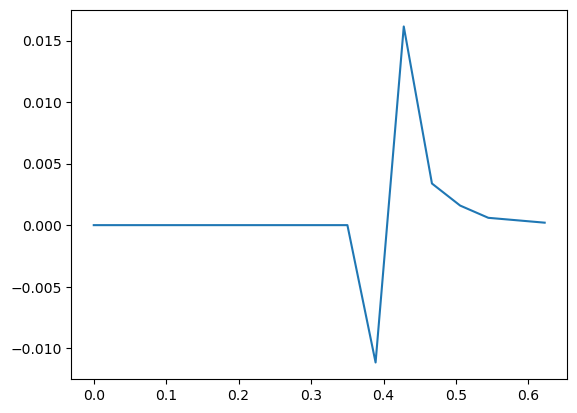

g-r
g-i
g-z
g-y
r-i
r-z
r-y
i-z
i-y
z-y


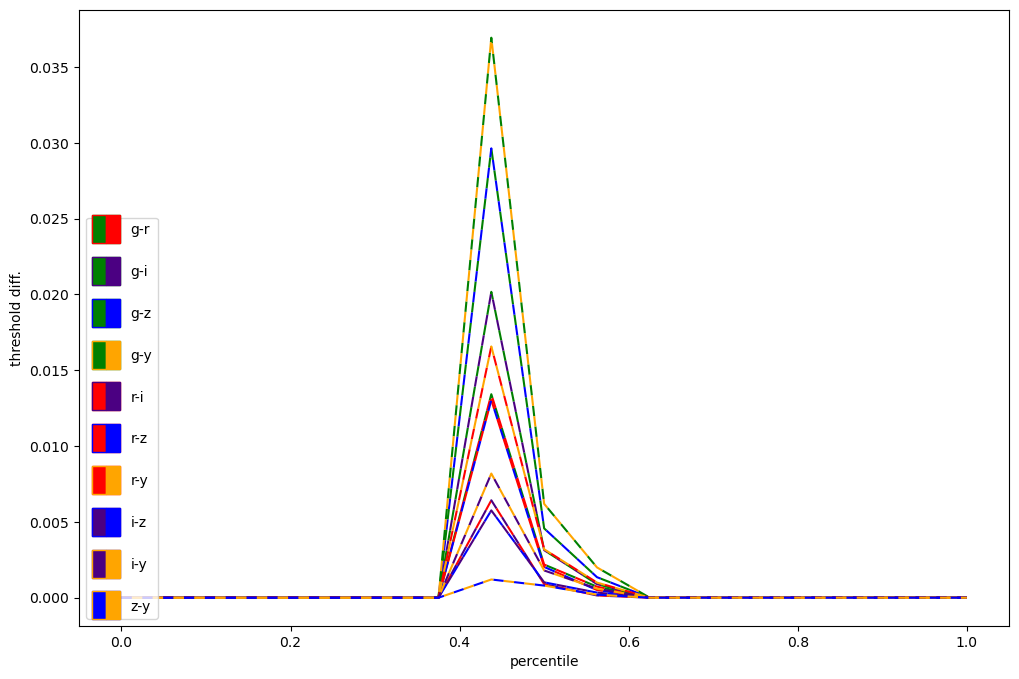

In [25]:
i = 1
dark_side = read_spin_parity_galaxies_label_from_csv(get_csv_path())
#gals = get_galaxy_list()
#gals = ['NGC3368']
gals = ['NGC5522']

for name in gals:
    #print(name)
    if name not in dark_side: continue
    print(i,name, dark_side[name])
    xs_dict = dict(); ys_dict = dict()
    for (first_band,base_band) in itertools.combinations(bands_in_order, 2):
        band_pair = "{}-{}".format(first_band,base_band)
        returned = construct_diff_percentile(name,first_band,base_band)
        if returned is None: continue
        (xs,ys) = returned
        xs_dict[band_pair] = xs; ys_dict[band_pair] = ys
    if len(xs_dict) >= 1:
        xt = xs_dict[list(xs_dict.keys())[0]]
        construct_diff_plot(xt,ys_dict)
    
    i += 1
    #if i > 2:
    #    break
    #break

In [11]:
np.linspace(0,1,17)

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    ])